This is a contest on Analytics Vidhya. The problem statement and data sets can be found in: https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler

from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2

import tensorflow as tf 
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

pd.options.mode.chained_assignment = None 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

In [9]:
train = pd.read_csv('train.csv', index_col=0)
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Loan_ID,,,,,,,,,,,,
LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [10]:
Xtrain = train.iloc[:, :-1]
Ytrain = train.Loan_Status.to_frame()
Xtest = pd.read_csv('test.csv', index_col=0)
del train

In [11]:
print('Xtrain = ', Xtrain.shape)
print('Xtest = ', Xtest.shape)

Xtrain =  (614, 11)
Xtest =  (367, 11)


In [5]:
Xtrain.info()

<class 'pandas.core.frame.DataFrame'>
Index: 614 entries, LP001002 to LP002990
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 57.6+ KB


Data includes 6 categorical and 5 numerical features as well as target labels in the "Loan status" column .

First, I perform univariate analysis to the dataset in order to understand and visualize the features individually.

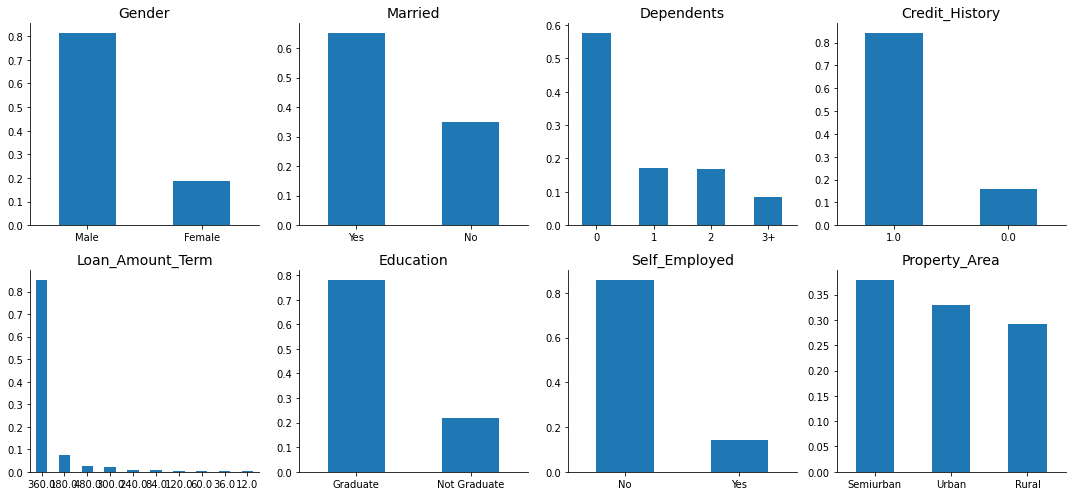

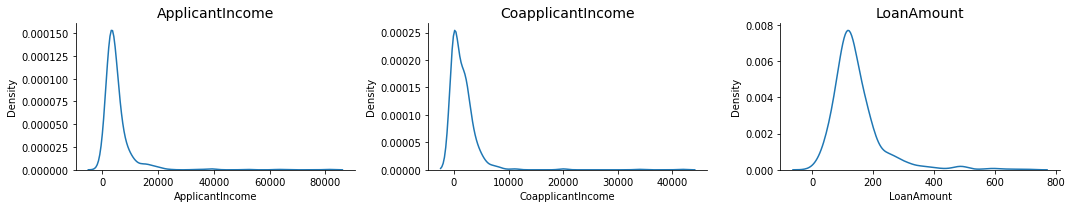

In [12]:
fig, ax = plt.subplots(2,4, figsize=(15,7))
columns = ["Gender", "Married", "Dependents",
           "Credit_History", "Loan_Amount_Term",
           "Education", "Self_Employed", "Property_Area"]

for i, col in enumerate(columns):
  Xtrain[col].value_counts(normalize=True).plot.bar(ax=ax[i//4, i%4], rot=0)
  ax[i//4, i%4].set_title('%s' %col, fontsize=14)  

plt.tight_layout()

fig, ax = plt.subplots(1,3, figsize=(15,3))
for i, col in enumerate(["ApplicantIncome",
                         "CoapplicantIncome",
                         "LoanAmount"]):
  sns.kdeplot(Xtrain[col], ax=ax[i])
  ax[i].set_title('%s' %col, fontsize=14)  
plt.tight_layout()       

We can see from the above histograms that distributions for "Applicant Income", "Coapplicant Income" and "Loan Amount" are right-skewed. 

Next, I will look at their box plots.



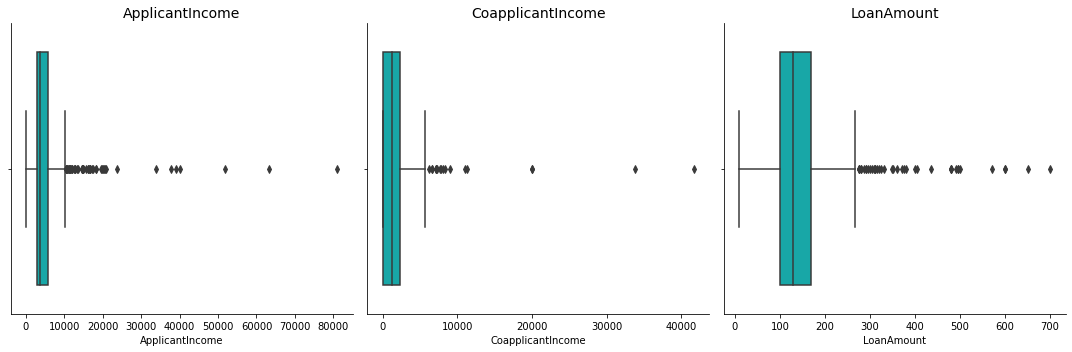

In [13]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
for i, col in enumerate(["ApplicantIncome",
                         "CoapplicantIncome",
                         "LoanAmount"]):
  sns.boxplot(x=Xtrain[col], ax=ax[i], color='c')
  ax[i].set_title('%s' %col, fontsize=14)  
  plt.tight_layout()  

From the box plots we can see the presence of outliers in these features. I will deal with the outliers later. First, I will perform a bivariate analysis to see how features are related to the target labels.

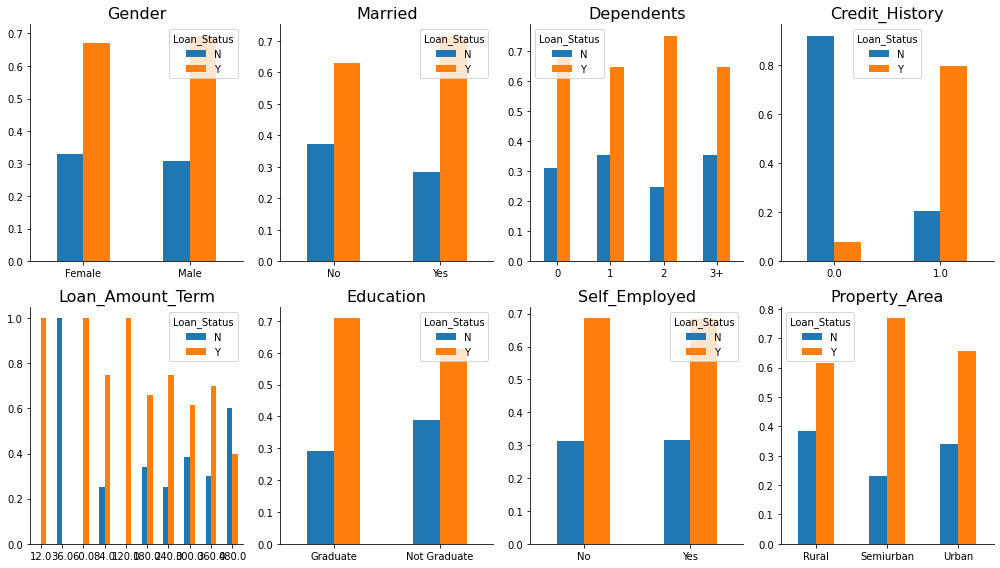

In [14]:
# Crosstab for categorical features
fig, ax = plt.subplots(2,4, figsize=(14,8))
columns = ["Gender", "Married","Dependents",
           "Credit_History", "Loan_Amount_Term",
           "Education", "Self_Employed", "Property_Area"]

for i, col in enumerate(columns):
  ct = pd.crosstab(Xtrain[col], Ytrain['Loan_Status'])
  ct.div(ct.sum(1), axis=0).plot(kind='bar', ax=ax[i//4, i%4], rot=0)
  ax[i//4, i%4].set_title('%s' %col, fontsize=16)
  ax[i//4, i%4].set_xlabel(None)
  plt.tight_layout() 

Applicants with higher credit history or education are more likely to get approved for a loan. Also married people and people from semiurban area are more likely to get approved. Gender and being self-employed doesn't make a difference much.

Next, I will look at the continuous features. For continuous features, I discretize them by cutting the data into different bins.




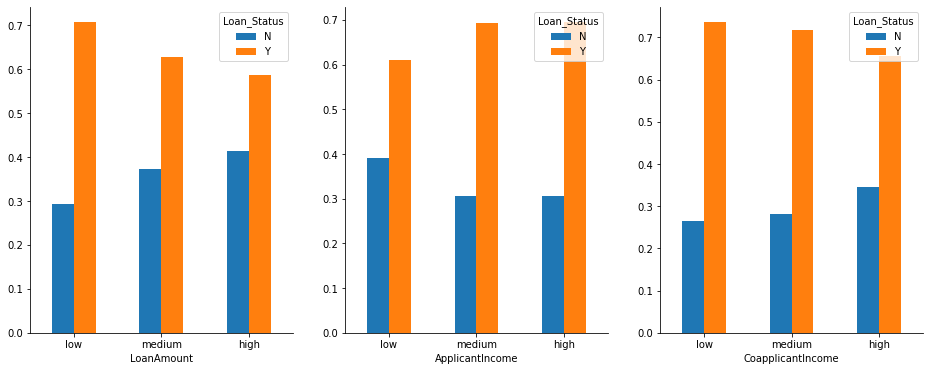

In [15]:
# Crosstab for continuous features
df = Xtrain.copy()
fig, ax = plt.subplots(1,3, figsize=(16,6))
loan_bins = np.array([0, 2, 3, 8])*100
coap_bins = np.array([0, 2, 5, 40])*1000
ap_bins = np.array([0, 2, 5, 80])*1000

labels = ['low', 'medium', 'high']

df['LoanAmount'] = pd.cut(df['LoanAmount'], bins=loan_bins, labels=labels)
df['ApplicantIncome'] = pd.cut(df['ApplicantIncome'], bins=ap_bins, labels=labels)
df['CoapplicantIncome'] = pd.cut(df['CoapplicantIncome'], bins=coap_bins, labels=labels)

loan_ct = pd.crosstab(df['LoanAmount'], Ytrain['Loan_Status'])
app_ct = pd.crosstab(df['ApplicantIncome'], Ytrain['Loan_Status'])
coap_ct = pd.crosstab(df['CoapplicantIncome'], Ytrain['Loan_Status'])

loan_ct.div(loan_ct.sum(1), axis=0).plot(kind="bar", ax=ax[0], rot=0)
app_ct.div(app_ct.sum(1), axis=0).plot(kind="bar", ax=ax[1], rot=0)
coap_ct.div(coap_ct.sum(1), axis=0).plot(kind="bar", ax=ax[2], rot=0)
plt.show()

It is reasonable to assume that applicants with higher "coapplicant incomes" are more likely to get approved for a loan than applicants with medium or low "coapplicant income", but the last plot shows the opposite. Now let's see what happens if I lower the maximum bin edge in "coapplicant income" from 40,000 to 10,000.

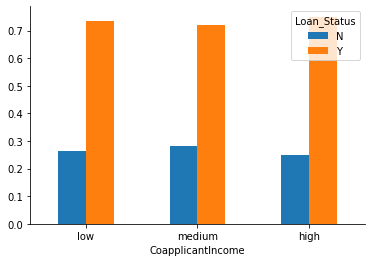

In [16]:
df = Xtrain.copy()
coap_bins = np.array([0, 2, 5, 10])*1000
labels = ['low', 'medium', 'high']
df['CoapplicantIncome'] = pd.cut(df['CoapplicantIncome'], bins=coap_bins, labels=labels)
coap_ct = pd.crosstab(df['CoapplicantIncome'], Ytrain['Loan_Status'])
coap_ct.div(coap_ct.sum(1), axis=0).plot(kind="bar", rot=0)
plt.show()

Now it makes sense. Therefore, we conclude that there are actually outliers in this feature. These ouliers can be removed using IQR method. 

In the next cell, I have chosen the proper quartiles so that the range of this feature becomes close to (0,10000) as I discussed before.

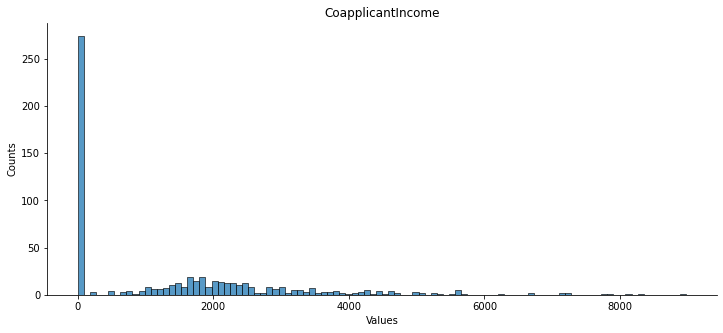

In [17]:
# IQR method
th1, th2 = np.percentile(Xtrain["CoapplicantIncome"],[0,92])
iqr = th2 - th1
lower_bound = th1 -(1.5 * iqr) 
upper_bound = th2 +(1.5 * iqr)
indexes= Xtrain[(Xtrain["CoapplicantIncome"] > upper_bound)
               |(Xtrain["CoapplicantIncome"] < lower_bound)].index
Xtrain = Xtrain.drop(indexes).reset_index(drop=True)
Ytrain = Ytrain.drop(indexes).reset_index(drop=True)

plt.figure(1, figsize=(12,5))
sns.histplot(Xtrain['CoapplicantIncome'], bins=100)
plt.title('CoapplicantIncome')
plt.xlabel('Values')
plt.ylabel('Counts')
plt.show()

Another way to deal with outliers in our data is to use the log transformation. The reason is that the features on the box plots are right skewed and Log has this property that it doesn't affect smaller values much, but it reduces large values. Therefore after applying the log transformation, we expect to see histograms become more similar to a normal distribution or more symmetric and this reduces the effect of big outliers.

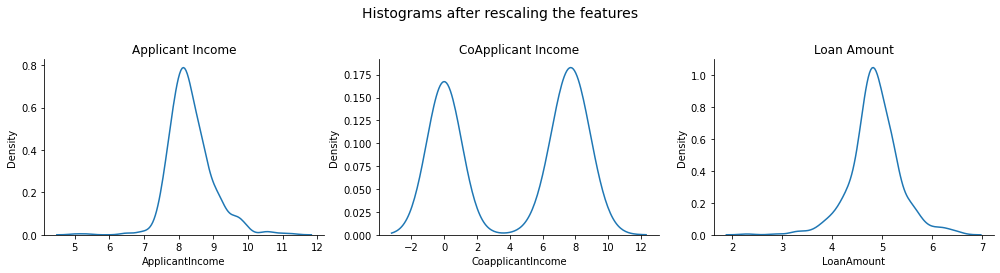

In [18]:
#  We can apply log transformation to the right-skewed data
Xtrain['CoapplicantIncome'] = Xtrain['CoapplicantIncome'].apply(lambda x: np.log(1+x))
Xtrain['LoanAmount'] = Xtrain['LoanAmount'].apply(lambda x: np.log(1+x))
Xtrain['ApplicantIncome'] = Xtrain['ApplicantIncome'].apply(lambda x: np.log(1+x))
 
Xtest['CoapplicantIncome'] = Xtest['CoapplicantIncome'].apply(lambda x: np.log(1+x))
Xtest['LoanAmount'] = Xtest['LoanAmount'].apply(lambda x: np.log(1+x))
Xtest['ApplicantIncome'] = Xtest['ApplicantIncome'].apply(lambda x: np.log(1+x))

plt.figure(figsize=(14,9))
plt.subplot(331)
sns.kdeplot(Xtrain['ApplicantIncome'])
plt.title('Applicant Income')
plt.subplot(332)
sns.kdeplot(Xtrain['CoapplicantIncome'])
plt.title('CoApplicant Income')
plt.subplot(333)
sns.kdeplot(Xtrain['LoanAmount'])
plt.title('Loan Amount')
plt.tight_layout()
plt.suptitle('Histograms after rescaling the features', fontsize=14, y=1.04)
plt.show()

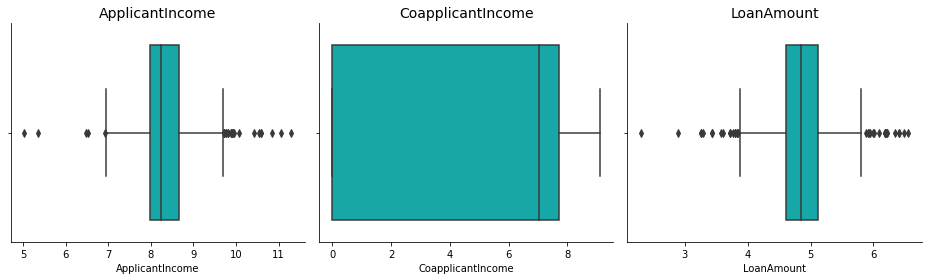

In [19]:
fig, ax = plt.subplots(1,3, figsize=(13,4))
for i, col in enumerate(["ApplicantIncome",
                         "CoapplicantIncome",
                         "LoanAmount"]):
  sns.boxplot(x=Xtrain[col], ax=ax[i], color='c')
  ax[i].set_title('%s' %col, size=14)  
  plt.tight_layout() 

From the box plots we can see that log transformation has reduced the amount of outliers (compare them with the previous box plots.)

Next, I will do the multivariate analysis to see how the features are correlated with each other. Since data includes object type categorical values, I use pd.factorize() to convert them into numerical values first and then apply the Pearson correlation to them.

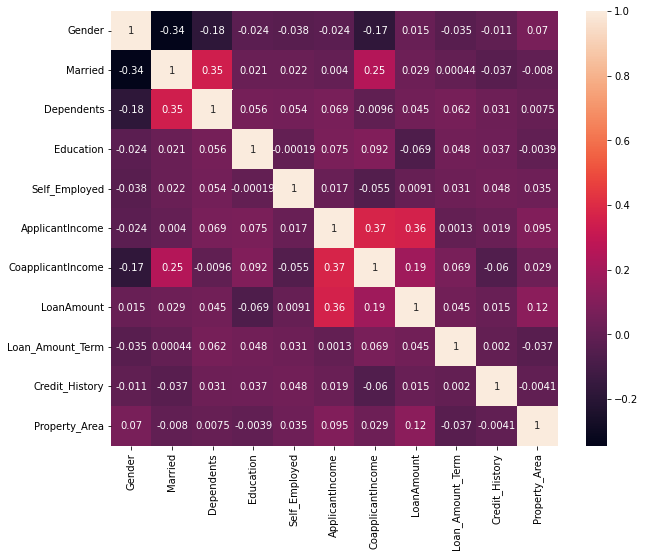

In [20]:
corr = Xtrain.apply(lambda x: pd.factorize(x)[0]).corr(method='pearson')
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap=None)
plt.show()

From the heatmap we can see Gender, Married and Dependents are highly correlated to each other. Moreover Applicant income, CoapplicanIncome and LoanAmount are highly correlated.

We can also see Gender is almost uncorrelated to the target variables, "Loan_Status", and so it doesn't count toward the learning. Therefore, we can remove this feature from dataset to lower the computational costs.

In [21]:
Xtrain.drop(['Gender'], axis=1, inplace=True)
Xtest.drop(['Gender'], axis=1, inplace=True)

After removing the ouliers and uncorrelated features, we can handle the missing values.

In [22]:
Xtrain.isnull().sum()

Married               3
Dependents           15
Education             0
Self_Employed        31
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       49
Property_Area         0
dtype: int64

In [23]:
Xtest.isnull().sum()

Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [24]:
for col in ["Married", "Dependents",
            "Credit_History",
            "Loan_Amount_Term"]:
  Xtrain[col].fillna(Xtrain[col].mode()[0], inplace=True)
  Xtest[col].fillna(Xtrain[col].mode()[0], inplace=True)

Xtrain['LoanAmount'].fillna(Xtrain['LoanAmount'].median(), inplace=True)
Xtest['LoanAmount'].fillna(Xtrain['LoanAmount'].median(), inplace=True)

Xtrain = pd.get_dummies(Xtrain, columns=["Self_Employed"], drop_first=False)
Xtest = pd.get_dummies(Xtest, columns=["Self_Employed"], drop_first=False)

In [25]:
print(Xtrain.isnull().sum())

Married              0
Dependents           0
Education            0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Self_Employed_No     0
Self_Employed_Yes    0
dtype: int64


In [26]:
print(Xtest.isnull().sum())

Married              0
Dependents           0
Education            0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Self_Employed_No     0
Self_Employed_Yes    0
dtype: int64


In next step I will convert object type values to numerical values.

I use the bivariate analysis and look at the bar plots to complete this task. For "Self_Employed", since different categories had the same chance for loan approval (there is no order) I will encode them with one-hot encoding.

For Married and Education features since different categories have different chance of approval I will use oridinal encoding because it seems that we actually have an ordinal relationship here: Married > Not Married and Graduate > Not Graduate.

I will apply these ideas to all features.

In [27]:
# Convert all values to numeric values
# Ordinal encoding
Xtrain['Dependents'] = [0.0 if x=='1' else 1.0 if x=='3+' else 2.0 if x=='0'
                     else 3.0 if x=='2' else np.NaN for x in Xtrain['Dependents']]    
Xtest['Dependents'] = [0.0 if x=='1' else 1.0 if x=='3+' else 2.0 if x=='0'
                     else 3.0 if x=='2' else np.NaN for x in Xtest['Dependents']] 
Xtrain['Married'] = [1.0 if x=='Yes' else 0.0 if x=='No' else np.NaN
                        for x in Xtrain['Married']]                     
Xtest['Married'] = [1.0 if x=='Yes' else 0.0 if x=='No' else np.NaN
                     for x in Xtest['Married']]  
Xtrain['Education'] = [1.0 if x=='Graduate' else 0.0 if x=='Not Graduate' else np.NaN
                          for x in Xtrain['Education']]                     
Xtest['Education'] = [1.0 if x=='Graduate' else 0.0 if x=='Not Graduate' else np.NaN
                       for x in Xtest['Education']]                                          
Xtrain['Property_Area'] = [0.0 if x=='Rural' else 1.0 if x=='Urban' else 2.0 if x=='Semiurban'
                              else np.NaN for x in Xtrain['Property_Area']]                     
Xtest['Property_Area'] = [0.0 if x=='Rural' else 1.0 if x=='Urban' else 2.0 if x=='Semiurban'
                          else np.NaN for x in Xtest['Property_Area']] 

Ytrain['Loan_Status'] = [1.0 if x=='Y' else 0.0 for x in Ytrain['Loan_Status']]

In [28]:
Xtest.head()

,Married,Dependents,Education,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Self_Employed_No,Self_Employed_Yes
Loan_ID,,,,,,,,,,,
LP001015,1.0,2.0,1.0,8.651899,0.000000,4.709530,360.0,1.0,1.0,1,0
LP001022,1.0,0.0,1.0,8.031710,7.313887,4.844187,360.0,1.0,1.0,1,0
LP001031,1.0,3.0,1.0,8.517393,7.496097,5.342334,360.0,1.0,1.0,1,0
LP001035,1.0,3.0,1.0,7.758333,7.842671,4.615121,360.0,1.0,1.0,1,0
LP001051,0.0,2.0,0.0,8.094684,0.000000,4.369448,360.0,1.0,1.0,1,0


The below histogram plot shows that data is imbalanced. We need to use proper metrics (such precision_recall, f1 or roc) while training the dataset.

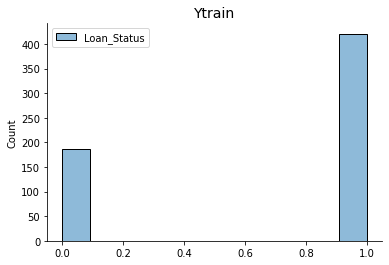

In [29]:
sns.histplot(Ytrain)
plt.title('Ytrain', size=14)
plt.show()

In [30]:
print('Ytrain = ', Ytrain.shape)
num_ones = sum(Ytrain['Loan_Status'])
ratio = num_ones / (Ytrain.shape[0]-num_ones) 
print('ratio of accepted to rejected  = ', ratio)

Ytrain =  (608, 1)
ratio of accepted to rejected  =  2.251336898395722


In [31]:
# Feature scaling
scaler = MinMaxScaler()
Xtrain = scaler.fit_transform(Xtrain)
Xtest = scaler.transform(Xtest)

Finally, I use XGBoost model to train the dataset. XGBoost is a highly efficient decision-tree based model, widely used in data science competitions. This model is presented by Tianqi Chen and Carlos Guestrin in this paper:

" XGBoost: A Scalable Tree Boosting System ".

Hyperparameter tuning is key concept here. Moreover, for the imbalanced dataset, it's important to tune  the 'scale_pos_weight' parameter and set to the ratio of majority class to the minority class. 



In [35]:
model = XGBClassifier()
cv = RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42)
grid = {}
grid['n_estimators'] = [1, 5, 10, 20, 50]
grid['max_depth'] = [1, 5, 10, 15, 20]
grid['scale_pos_weight'] = [1, 2.25, 3, 5, 10]
search = GridSearchCV(model, param_grid=grid, cv=cv, scoring='roc_auc')
history = search.fit(Xtrain, Ytrain.values.ravel())

print('history = ', history, '\n')
print('best parameters = ', history.best_params_)
print('best score = ', history.best_score_)

means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

history =  GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
             estimator=XGBClassifier(),
             param_grid={'max_depth': [1, 5, 10, 15, 20],
                         'n_estimators': [1, 5, 10, 20, 50],
                         'scale_pos_weight': [1, 2.25, 3, 5, 10]},
             scoring='roc_auc') 

best parameters =  {'max_depth': 20, 'n_estimators': 50, 'scale_pos_weight': 2.25}
best score =  0.7581250930944935
0.708507 (0.052054) with: {'max_depth': 1, 'n_estimators': 1, 'scale_pos_weight': 1}
0.708507 (0.052054) with: {'max_depth': 1, 'n_estimators': 1, 'scale_pos_weight': 2.25}
0.708507 (0.052054) with: {'max_depth': 1, 'n_estimators': 1, 'scale_pos_weight': 3}
0.708507 (0.052054) with: {'max_depth': 1, 'n_estimators': 1, 'scale_pos_weight': 5}
0.708507 (0.052054) with: {'max_depth': 1, 'n_estimators': 1, 'scale_pos_weight': 10}
0.708507 (0.052054) with: {'max_depth': 1, 'n_estimators': 5, 'scale_pos_weight': 1}
0.708507 (0.052

The best value for the parameter 'scale_pos_weight' is 2.25 which is the ratio of majority to the minority class.

We can keep exploring for 'max_depth' and 'n_estimators'. 

In [36]:
grid['n_estimators'] = [50, 60, 70, 80]
grid['max_depth'] = [20, 30, 40, 50]
grid['scale_pos_weight'] = [2.25]
search = GridSearchCV(model, param_grid=grid, cv=cv, scoring='roc_auc')
history = search.fit(Xtrain, Ytrain.values.ravel())

print('history = ', history, '\n')
print('best parameters = ', history.best_params_)
print('best score = ', history.best_score_)

means = search.cv_results_['mean_test_score']
stds = search.cv_results_['std_test_score']
params = search.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

history =  GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=5, n_splits=10, random_state=42),
             estimator=XGBClassifier(),
             param_grid={'max_depth': [20, 30, 40, 50],
                         'n_estimators': [50, 60, 70, 80],
                         'scale_pos_weight': [2.25]},
             scoring='roc_auc') 

best parameters =  {'max_depth': 20, 'n_estimators': 60, 'scale_pos_weight': 2.25}
best score =  0.7588786565897948
0.758125 (0.075607) with: {'max_depth': 20, 'n_estimators': 50, 'scale_pos_weight': 2.25}
0.758879 (0.076791) with: {'max_depth': 20, 'n_estimators': 60, 'scale_pos_weight': 2.25}
0.756982 (0.076766) with: {'max_depth': 20, 'n_estimators': 70, 'scale_pos_weight': 2.25}
0.755966 (0.075610) with: {'max_depth': 20, 'n_estimators': 80, 'scale_pos_weight': 2.25}
0.758695 (0.076451) with: {'max_depth': 30, 'n_estimators': 50, 'scale_pos_weight': 2.25}
0.758230 (0.078209) with: {'max_depth': 30, 'n_estimators': 60, 'scale_pos_weight': 2.25}
0.7566

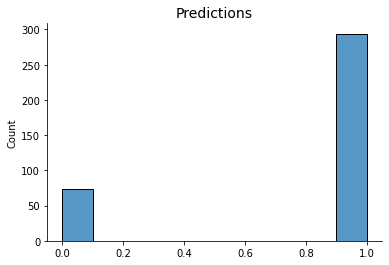

In [47]:
grid_params = {'max_depth': 20, 'n_estimators': 60, 'scale_pos_weight': 2.25}
model = XGBClassifier(**grid_params)
model.fit(Xtrain, Ytrain.values.ravel())
Predictions = model.predict(Xtest)

sns.histplot(Predictions)
plt.title('Predictions', size=14)
plt.show()